In [1]:
import torch
import torch.utils
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [2]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, data_dim, hidden_dim):
        super().__init__()
        self.linear1 = nn.Linear(latent_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, data_dim)

    def forward(self, x):
        y = self.linear1(x)
        y = F.relu(y)
        return self.linear2(y)

In [3]:
class Encoder(nn.Module):
    def __init__(self, data_dim, latent_dim, hidden_dim):
        super().__init__()
        self.linear1 = nn.Linear(data_dim, hidden_dim)
        self.linear_mean = nn.Linear(hidden_dim, latent_dim)
        self.linear_logvar = nn.Linear(hidden_dim, latent_dim)

    def forward(self, x):
        y = self.linear1(x)
        y = F.relu(y)
        return self.linear_mean(y), torch.exp(self.linear_logvar(y)/2)

In [4]:
class VAEMultiLayer(nn.Module):
    def __init__(self, data_dim, latent_dim, hidden_dim, layer_num):
        super().__init__()
        self.output_dec = Decoder(latent_dim, data_dim, hidden_dim)
        self.latent_decs = [Decoder(latent_dim, latent_dim, hidden_dim) for i in range(layer_num - 1)]
        self.input_enc = Encoder(data_dim, latent_dim, hidden_dim)
        self.latent_encs = [Encoder(latent_dim, latent_dim, hidden_dim) for i in range(layer_num - 1)]
        self.latent_dim = latent_dim
        self.layer_num = layer_num

    def get_loss(self, x):
        e = torch.randn(self.layer_num, len(x), self.latent_dim)
        mu = []
        sigma = []
        z = []

        tmp_mu, tmp_sigma = self.input_enc(x)
        mu.append(tmp_mu)
        sigma.append(tmp_sigma)
        z.append(mu[0] + sigma[0]*e[0])
        for i, enc in enumerate(self.latent_encs):
            tmp_mu, tmp_sigma = enc(z[i])
            mu.append(tmp_mu)
            sigma.append(tmp_sigma)
            z.append(mu[i+1] + sigma[i+1]*e[i+1])
        
        loss = 0
        x_hat = self.output_dec(z[0])
        loss += F.mse_loss(x, x_hat, reduction='sum')
        for i, dec in enumerate(self.latent_decs):
            var = sigma[i]**2
            z_hat = dec(z[i+1])
            loss += -(1 + torch.log(var) - (mu[i]-z_hat)**2 - var).sum()
        var = sigma[-1]**2
        loss += -(1 + torch.log(var) - mu[-1]**2 -var).sum()

        return loss
    
    def genearte(self, n=1):
        z = torch.randn(n, self.latent_dim)
        for dec in reversed(self.latent_decs):
            z_hat = dec(z)
            z = z_hat + torch.randn(n, self.latent_dim)
        return self.output_dec(z)


In [7]:
batch_size = 200
latent_dim = 20
hidden_dim = 100
layer_num = 3
epoch_num = 50

In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(torch.flatten)
])

dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    transform=transform,
    download=True
)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

Files already downloaded and verified


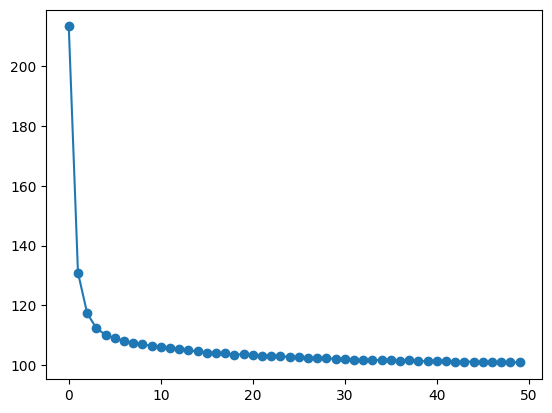

In [8]:
torch.random.manual_seed(0)

vae = VAEMultiLayer(len(dataset[0][0]), latent_dim, hidden_dim, layer_num)
optimizer = torch.optim.Adam(vae.parameters())
loss_sum_rec = []

for epoch in range(epoch_num):
    loss_sum_rec.append(0)
    for x, label in dataloader:
        loss = vae.get_loss(x)
        loss_sum_rec[-1] += loss.item()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    loss_sum_rec[-1] /= len(dataset)
    plt.clf()
    plt.plot(range(len(loss_sum_rec)), loss_sum_rec, marker='o')
    plt.pause(0.00001)
    clear_output(wait=True)

In [ ]:
sample_num = 256
with torch.no_grad():
    